In [29]:
import sys
sys.path.insert(0, '/home/ektov-av/python35-libs/lib/python3.5/site-packages/') 

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import re, os, time, sys, datetime, csv
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.externals import joblib
import xgboost.compat
import xgboost as xgb
import lightgbm as gbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV  

import sklearn.cross_validation
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale, MinMaxScaler, Imputer
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
import datetime
import cx_Oracle
import seaborn as sns
from matplotlib import pyplot as mplt
from sklearn import preprocessing
import re
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, \
                            roc_curve, precision_recall_curve, average_precision_score, f1_score, \
                            classification_report, average_precision_score, confusion_matrix 
from sklearn.preprocessing import normalize, binarize

from label_encoder import SoftLabelEncoder
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt

from support_library.plot import Plot as mplt
from support_library.feature_eng import Featureng as fe

In [30]:
% matplotlib inline

In [31]:
def get_path(folder, file):
    return os.path.join(folder, file)

In [32]:
def getboostparams(model_name, X_trn, y_trn, X_tst, y_tst):
    switcher={
        LGBMClassifier:
                        {'params': 
                                    {
                                        'n_estimators':10000, 
                                        'num_leaves':150, 
                                        'max_bin':100, 
                                        'bagging_fraction':0.8, 
                                        'bagging_freq':10, 
                                        'n_jobs':60, 
                                        'feature_fraction':0.5, 
                                        'lambda_l1':0, 
                                        'lambda_l2':1, 
                                        'min_child_weight':1e-05,
                                        'min_data_in_leaf':100, 
                                        'random_state':42
                                    },
                         'fit_params': 
                                    {
                                        'eval_set': [(X_trn, y_trn),
                                                     (X_tst, y_tst)], 
                                        'early_stopping_rounds': 15,
                                        'eval_metric': ['auc', 'logloss'], 
                                        'verbose': False
                                    }
                        },
        XGBClassifier:
                        {'params':        
                                    {
                                         'base_score': 0.5,
                                         'booster': 'gbtree',
                                         'colsample_bylevel': 1,
                                         'colsample_bytree': 0.6,
                                         'gamma': 5,
                                         'learning_rate': 0.1,
                                         'max_delta_step': 0,
                                         'max_depth': 10,
                                         'min_child_weight': 10,
                                         'missing': None,
                                         'n_estimators': 10000,
                                         'n_jobs': 60,
                                         'objective': 'binary:logistic',
                                         'random_state': 0,
                                         'reg_alpha': 0,
                                         'reg_lambda': 1,
                                         'scale_pos_weight': 1,
                                         'seed': 42,
                                         #'silent': True,
                                         'subsample': 1.0
                                    },
                         'fit_params': 
                                    {
                                        'eval_set': [(X_trn, y_trn),
                                                     (X_tst, y_tst)], 
                                        'early_stopping_rounds': 15,
                                        'eval_metric': ['auc', 'logloss'], 
                                        'verbose': False
                                    }                        
                        
                        },
        
        RandomForestClassifier:
                        {'params':           
                                    {
                                        'n_estimators': 10000, 
                                        'criterion': 'gini', 
                                        'max_depth': None, 
                                        'min_samples_split':2, 
                                        'min_samples_leaf':1, 
                                        'min_weight_fraction_leaf':0.0, 
                                        'max_features': 'auto', 
                                        'max_leaf_nodes': None, 
                                        'min_impurity_decrease': 0.0,
                                        'bootstrap': True, 
                                        'oob_score': False, 
                                        'n_jobs': 40, 
                                        'random_state': 32, 
                                        'verbose': 0
                                    },
                         'fit_params': {}
                        }
    }
    

    params     = switcher.get(model_name)['params']
    fit_params = switcher.get(model_name)['fit_params']
    
    return params, fit_params

In [33]:
def predict(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    print('AUC: %.5f, Precision: %.5f, Recall: %.5f, F1: %.5f \n' % (roc_auc_score(y_test, y_pred_proba), \
                                    precision_score(y_test, y_pred), recall_score(y_test, y_pred), 
                                                                     f1_score(y_test, y_pred)))
    print('Average precision: %.5f \n' % average_precision_score(y_test, y_pred_proba))
    print(classification_report(y_test, y_pred, digits=5))
    mplt.confusion_matrix_heatmap(y_test, y_pred)

In [34]:
def eval_model(model, X, y, threshold=0.5):
    if model is XGBClassifier: 
        y_pred_proba = model.predict_proba(X, ntree_limit=model.best_ntree_limit)[:, 1]
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]
        
    y_pred = binarize(y_pred_proba.reshape(-1,1), threshold=threshold).reshape(-1).astype(int)
    #y_pred[X.cluster == 0] = 0

    TP = np.sum(np.logical_and(y_pred == 1, y == 1))
    TN = np.sum(np.logical_and(y_pred == 0, y == 0))
    FP = np.sum(np.logical_and(y_pred == 1, y == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y == 1))
    
    print('-' * 68)
    if model is XGBClassifier:
        print('AUC:%.5f, Precision:%.5f, Recall:%.5f, Trees:%d, True:%d of %d, Total:%d, Tr:%.2f' %
              (roc_auc_score(y, y_pred_proba),
               precision_score(y, y_pred),
               recall_score(y, y_pred),
               model.best_ntree_limit, TP, TP+FP, TP+FN,
               threshold), flush=True)
    else:
         print('AUC:%.5f, Precision:%.5f, Recall:%.5f, True:%d of %d, Total:%d, Tr:%.2f' %
              (roc_auc_score(y, y_pred_proba),
               precision_score(y, y_pred),
               recall_score(y, y_pred), TP, TP+FP, TP+FN,
               threshold), flush=True)       
    print('-' * 68)
    
    return y_pred, y_pred_proba

In [35]:
def train_full(X_train, X_test, y_train, y_test, model_name, cat_features, 
               cattopoly, threshold=0.5, save_dict=False):
 
    diff_df = joblib.load(get_path('pkl_store', 'KS_diff_df.pkl'))
    toremove=list(set(diff_df.feature)-set(cat_features+cattopoly))
    
    X_trn, X_tst = fe.features_endineering( X_train, X_test, 
                                            y_train, 
                                            cat_features, 
                                            cattopoly, 
                                            save_dict=save_dict)

    X_trn=X_trn.loc[:,~X_trn.columns.isin(toremove)]
    X_tst=X_tst.loc[:,~X_tst.columns.isin(toremove)]     
    
    imp=Imputer(missing_values='NaN', strategy='median', axis=1)
    X_trn=pd.DataFrame(imp.transform(X_trn), columns=X_trn.columns)
    X_tst=pd.DataFrame(imp.transform(X_tst), columns=X_tst.columns)

    X_trn,_ = fe.feature_scale_trans(X_trn)
    X_tst,_ = fe.feature_scale_trans(X_tst)    


    params, fit_params = getboostparams(model_name, X_trn, y_train, X_tst, y_test)
    model=model_name(**params)
    model.fit( X_trn, y_train, **fit_params )
        
    joblib.dump(model, get_path('pkl_store', model_name.__name__ + '_f.pkl'), compress=9)
    
    y_val, y_val_proba = eval_model(model, X_tst, y_test, threshold=threshold)

    mplt.auc_curve(y_test, y_val_proba)
    mplt.precision_recall_threshold_curve(y_test, y_val_proba)
    mplt.precision_recall_curve(y_test, y_val_proba)
    mplt.distplot(y_val_proba)
    mplt.feature_impotance(model, X_trn, count_top_features = 20)  
    

    return y_val, y_val_proba

In [36]:
def train(X, y, columns, model_name, cat_features, cattopoly, n_folds=4, 
          log=True, threshold=0.5, save_dict=False):

    blend_train       = np.zeros(X.shape[0])
    blend_train_proba = np.zeros(X.shape[0])
    
    diff_df = joblib.load(get_path('pkl_store', 'KS_diff_df.pkl'))
    toremove=list(set(diff_df.feature)-set(cat_features+cattopoly))
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        
        X_trn, X_tst = X.iloc[train_index], X.iloc[test_index]
        y_trn, y_tst = y.iloc[train_index], y.iloc[test_index]
        
        X_trn, X_tst = fe.features_endineering(X_trn, X_tst, y_trn, 
                                               cat_features, cattopoly, 
                                               save_dict=save_dict)
        
        X_trn=X_trn.loc[:,~X_trn.columns.isin(toremove)]
        X_tst=X_tst.loc[:,~X_tst.columns.isin(toremove)]  

        imp=Imputer(missing_values='NaN', strategy='median', axis=1)
        X_trn=pd.DataFrame(imp.transform(X_trn), columns=X_trn.columns)
        X_tst=pd.DataFrame(imp.transform(X_tst), columns=X_tst.columns)
        
        X_trn,_ = fe.feature_scale_trans(X_trn)
        X_tst,_ = fe.feature_scale_trans(X_tst)
        
        params, fit_params = getboostparams(model_name, X_trn, y_trn, X_tst, y_tst)
        model=model_name(**params)
        model.fit( X_trn, y_trn, **fit_params )          

        blend_train[test_index], blend_train_proba[test_index] = eval_model(model, X_tst, y_tst, 
                                                                            threshold=threshold)
        #joblib.dump(model, model_name, compress=9)
        
    if log: 
        print('-' * 68)
        #calculate metrics over whole dataset:
        TP = np.sum(np.logical_and(blend_train == 1, y == 1))
        TN = np.sum(np.logical_and(blend_train == 0, y == 0))
        FP = np.sum(np.logical_and(blend_train == 1, y == 0))
        FN = np.sum(np.logical_and(blend_train == 0, y == 1))

        print('AUC: %7.5f, Precision: %7.5f, Recall: %7.5f, True:%d of %d, Total:%d' %
              (roc_auc_score(y, blend_train_proba),
               precision_score(y, blend_train),
               recall_score(y, blend_train),
               TP, TP+FP, TP+FN), flush=True)

        print('f1_score: %.5f \n' % f1_score(y, blend_train))
        print('Average precision: %.5f \n' % average_precision_score(y, blend_train_proba))

        mplt.auc_curve(y, blend_train_proba)
        mplt.precision_recall_threshold_curve(y, blend_train_proba)
        mplt.feature_impotance(model, X, count_top_features = 20)
    
    return blend_train, blend_train_proba

In [37]:
df = pd.read_pickle('pkl_store/total_dataset_unencoded.pkl')

In [38]:
df.reset_index(inplace=True,drop=1)
df

,is_sold,tb,gosb,product,product_group,days_cr_q_end,segment_client,priority_client,sum_sold,sum_sold_cumulate,...,cash_management_ratio_share_prod_shift_3,overdraft_kredit_ratio_share_prod_shift_3,corporate_cards_ratio_share_prod_shift_3,spec_acc_ratio_share_prod_shift_3,samoinkass_ratio_share_prod_shift_3,obsluzh_rts_rur_ratio_share_prod_shift_3,days_between,is_previous_sold,days_between_km_dealdiff,is_previous_sold_km_dealdiff
0,1,Волго-Вятский банк,Банк Татарстан ГОСБ №8610,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,34,Микро,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Московский банк,Московский банк,Неснижаемый остаток,ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,34,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Московский банк,Московский банк,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,Сибирский банк,Красноярское ГОСБ №8646,Зарплатные проекты,ЗАРПЛАТНЫЕ ПРОЕКТЫ,32,Микро,Нет,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Центрально-Черноземный банк,ГО по Воронежской области,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Микро,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,Сибирский банк,Новосибирское ГОСБ №8047,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,Сибирский банк,Абаканское ГОСБ №8602,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,Сибирский банк,Новосибирское ГОСБ №8047,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,Московский банк,Московский банк,Зарплатные проекты,ЗАРПЛАТНЫЕ ПРОЕКТЫ,32,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,Уральский банк,Челябинское ГОСБ №8597,Неснижаемый остаток,ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
top_corr_features = pd.read_pickle('pkl_store/top_corr_features_le_all.pkl')

In [40]:
le=joblib.load(get_path('pkl_store', 'label_encoders_trn.pkl'))
cat_features=list(set(le.keys()))
cat_features

['product_group', 'segment_client', 'priority_client', 'product', 'gosb', 'tb']

In [41]:
# define base features to calculate polynomial features interactions 
cattopoly=[ 'product_avg_mean',
            'product_avg_std',
            'product_group_avg_mean',
            'product_group_avg_std',
            'gosb_avg_mean',
            'gosb_avg_std',
            'tb_avg_mean',
            'tb_avg_std',
            'priority_client_avg_mean',
            'priority_client_avg_std',
            'days_between_km_dealdiff',
            'sum_sold_total_cumulate_km_shift_3'
] 

In [42]:
balance = pd.concat([df.groupby('product_group')['is_sold'].sum(), 
                     df.groupby('product_group')['is_sold'].count()], axis=1)
balance.columns = ['Sum of sold', 'Count']
balance['balance'] = balance['Sum of sold'] / balance['Count']
balance = balance.sort_values('balance', ascending=False)
balance

,Sum of sold,Count,balance
product_group,,,
АРЕНДА СЕЙФОВ,1,1,1.000000
РОЗНИЧНЫЕ ПРОДУКТЫ,2,2,1.000000
СПЕЦ СЧЕТ ДЛЯ ТОРГОВ,3,3,1.000000
ВЕКСЕЛЯ,98,100,0.980000
ИНФОРМАЦИОННЫЕ УСЛУГИ,20790,21375,0.972632
РКО,76388,79676,0.958733
ИНКАССАЦИЯ,28442,29741,0.956323
ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,43806,47102,0.930024
ПАКЕТЫ УСЛУГ,36539,39663,0.921236


In [43]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['is_sold', 'days_cr_q_end'], dtype='object'),
 dtype('float64'): Index(['sum_sold', 'sum_sold_cumulate', 'sum_refused', 'sum_refused_cumulate',
        'sum_sold_total', 'sum_sold_total_cumulate', 'sum_refused_total',
        'sum_refused_tota_cumulate', 'sum_sold_company_shift_1',
        'sum_sold_cumulate_company_shift_1',
        ...
        'cash_management_ratio_share_prod_shift_3',
        'overdraft_kredit_ratio_share_prod_shift_3',
        'corporate_cards_ratio_share_prod_shift_3',
        'spec_acc_ratio_share_prod_shift_3',
        'samoinkass_ratio_share_prod_shift_3',
        'obsluzh_rts_rur_ratio_share_prod_shift_3', 'days_between',
        'is_previous_sold', 'days_between_km_dealdiff',
        'is_previous_sold_km_dealdiff'],
       dtype='object', length=261),
 dtype('O'): Index(['tb', 'gosb', 'product', 'product_group', 'segment_client',
        'priority_client'],
       dtype='object')}

In [44]:
dd=df.groupby('product_group')[['is_sold','days_between']].sum()
dd.loc[:,['is_sold','days_between']]

,is_sold,days_between
product_group,,
CASH MANAGEMENT,8,2863.0
АРЕНДА СЕЙФОВ,1,0.0
БАНКОВСКАЯ ГАРАНТИЯ,3254,103651.0
БИЗНЕС-КАРТА,39063,343725.0
ВАЛЮТНЫЙ КОНТРОЛЬ,287,5044.0
ВЕКСЕЛЯ,98,586.0
ВНЕШНИЙ МАЛЫЙ СМАРТ,9,497.0
ВНЕШНИЙ МИКРО СМАРТ,50,1309.0
ДЕЛОВАЯ СРЕДА,286,2136.0


In [45]:
product_groups_without_balance = list(balance[(balance['balance'] == 1) | (balance['balance'] == 0)].index)

In [46]:
df = df[~df['product_group'].isin(product_groups_without_balance)]

In [47]:
unique_counts = pd.DataFrame()
for col in df.columns:
    unique_counts = unique_counts.append([[col, len(df[col].unique())]])
unique_counts.columns = ['colname', 'unique_counts']
unique_counts.head()

,colname,unique_counts
0,is_sold,2
0,tb,14
0,gosb,90
0,product,135
0,product_group,28


In [48]:
non_unique_columns = unique_counts[unique_counts['unique_counts'] == 1]['colname'].values
non_unique_columns

array([], dtype=object)

In [49]:
target_column = 'is_sold'
#drop_columns = ['ckp']
#X, y = df.drop(target_column, axis = 1).drop(drop_columns, 1), df[target_column]
X, y = df.drop(non_unique_columns, axis = 1).drop(target_column, axis = 1), df[target_column]

In [84]:
X=X[top_corr_features]
X.head()

,product,product_group,days_cr_q_end,gosb,tb,days_between,priority_client,days_between_km_dealdiff,sum_sold_total_cumulate_km_shift_3,sum_sold_cumulate_agg_km_shift_1,...,ns_terminal_ratio_share_prod_shift_2,bank_straxovanie_lich_share_prod_shift_2,bank_straxovanie_lich_share_prod_shift_3,deposit_share_prod_shift_3,deposit_share_prod_shift_2,sum_sold_agg_company_shift_1,spec_acc,segment_client,invest_kredit,inkass
0,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,34,Банк Татарстан ГОСБ №8610,Волго-Вятский банк,NaN,Ключевой,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Микро,NaN,NaN
1,Неснижаемый остаток,ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,34,Московский банк,Московский банк,NaN,Ключевой,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Малые,NaN,NaN
2,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Московский банк,Московский банк,NaN,Ключевой,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Малые,NaN,NaN
3,Зарплатные проекты,ЗАРПЛАТНЫЕ ПРОЕКТЫ,32,Красноярское ГОСБ №8646,Сибирский банк,NaN,Нет,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Микро,NaN,NaN
4,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,ГО по Воронежской области,Центрально-Черноземный банк,NaN,Ключевой,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Микро,NaN,NaN


In [100]:
X.iloc[0,:].fillna(0).astype(bool)  

product                                      True
product_group                                True
days_cr_q_end                                True
gosb                                         True
tb                                           True
days_between                                False
priority_client                              True
days_between_km_dealdiff                    False
sum_sold_total_cumulate_km_shift_3          False
sum_sold_cumulate_agg_km_shift_1            False
sum_sold_total_cumulate_km_shift_2          False
sum_refused_tota_cumulate_km_shift_2        False
sum_sold_total_cumulate_agg_km_shift_3      False
sum_sold_total                              False
sum_refused_tota_cumulate                   False
sum_refused_tota_cumulate_km_shift_3        False
corporate_cards                             False
acquiring_torg                              False
sum_sold_cumulate_agg_km_shift_2            False
sum_sold_total_km_shift_3                   False


In [51]:
df1=df.groupby('product_group')['is_sold'].transform(lambda x: np.log((x.count()-x.sum())/x.count()))

In [52]:
df.groupby('product_group')['is_sold'].agg([('sum',lambda x: x.sum()),('count', lambda x: x.count()),
                                            ('ratio_1', lambda x: x.sum()/x.count()),
                                            ('ratio_0', lambda x: (x.count()-x.sum())/x.count())]).reset_index()

,product_group,sum,count,ratio_1,ratio_0
0,CASH MANAGEMENT,8,53,0.150943,0.849057
1,БАНКОВСКАЯ ГАРАНТИЯ,3254,5105,0.637414,0.362586
2,БИЗНЕС-КАРТА,39063,56386,0.692778,0.307222
3,ВАЛЮТНЫЙ КОНТРОЛЬ,287,344,0.834302,0.165698
4,ВЕКСЕЛЯ,98,100,0.980000,0.020000
5,ВНЕШНИЙ МАЛЫЙ СМАРТ,9,19,0.473684,0.526316
6,ВНЕШНИЙ МИКРО СМАРТ,50,92,0.543478,0.456522
7,ДЕЛОВАЯ СРЕДА,286,336,0.851190,0.148810
8,ДЕПОЗИТНЫЕ СЕРТИФИКАТЫ,59,67,0.880597,0.119403
9,ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ,2771,8664,0.319829,0.680171


## Train vs. Test dataset distributions

scaling all the data with mean-variance, but for columns where we have outliers (> 3x standard deviation) do a log-transform prior to scaling.

## 1.0. Data Pre-Processing
Current pre-processing procedure:
* Get rows from training set and test set and concatenate them
* Columns with standard deviation of 0 in training set removed
* Columns which are duplicate in training set removed
* Log-transform all columns which have significant outliers (> 3x standard deviation)
* Create datasets with: 
    * Mean-variance scale all columns including 0-values!
    * Mean-variance scale all columns **excluding** 0-values!

In [53]:
X_test   = pd.read_pickle('pkl_store/test_dataset_unencoded.pkl')

In [54]:
X_test=X_test[top_corr_features]

In [55]:
X.shape, X_test.shape

((445486, 158), (19860, 158))

In [56]:
X_trn=X.loc[:,~X.columns.isin(cat_features)]
X_tst=X_test.loc[:,~X_test.columns.isin(cat_features)]

In [57]:
imp=Imputer(missing_values='NaN', strategy='median', axis=1)

In [58]:
X_trn=pd.DataFrame(imp.transform(X_trn), columns=X_trn.columns)
X_tst=pd.DataFrame(imp.transform(X_tst), columns=X_tst.columns)

In [60]:
np.where(X_trn.isnull().sum())

(array([], dtype=int64),)

In [61]:
X_trn_scl, _ = fe.feature_scale_trans(X_trn)
X_tst_scl, _ = fe.feature_scale_trans(X_tst)

Removed 0 constant columns
Removed 0 constant columns


In [62]:
tot_df_scl = pd.concat([X_trn_scl, X_tst_scl], axis=0, sort=False)

In [64]:
tot_df_scl.reset_index(inplace=True)
tot_df_scl.drop(['index'], axis=1, inplace=True)

In [65]:
# Train and test
train_idx = range(0, len(X_trn))
test_idx = range(len(X_trn), len(tot_df_scl))

In [121]:
# tot_df_scl, tot_df_all_scl = fe.feature_scale_trans(total_df)

In [66]:
np.where(tot_df_scl.isnull().sum().values)

(array([], dtype=int64),)

/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


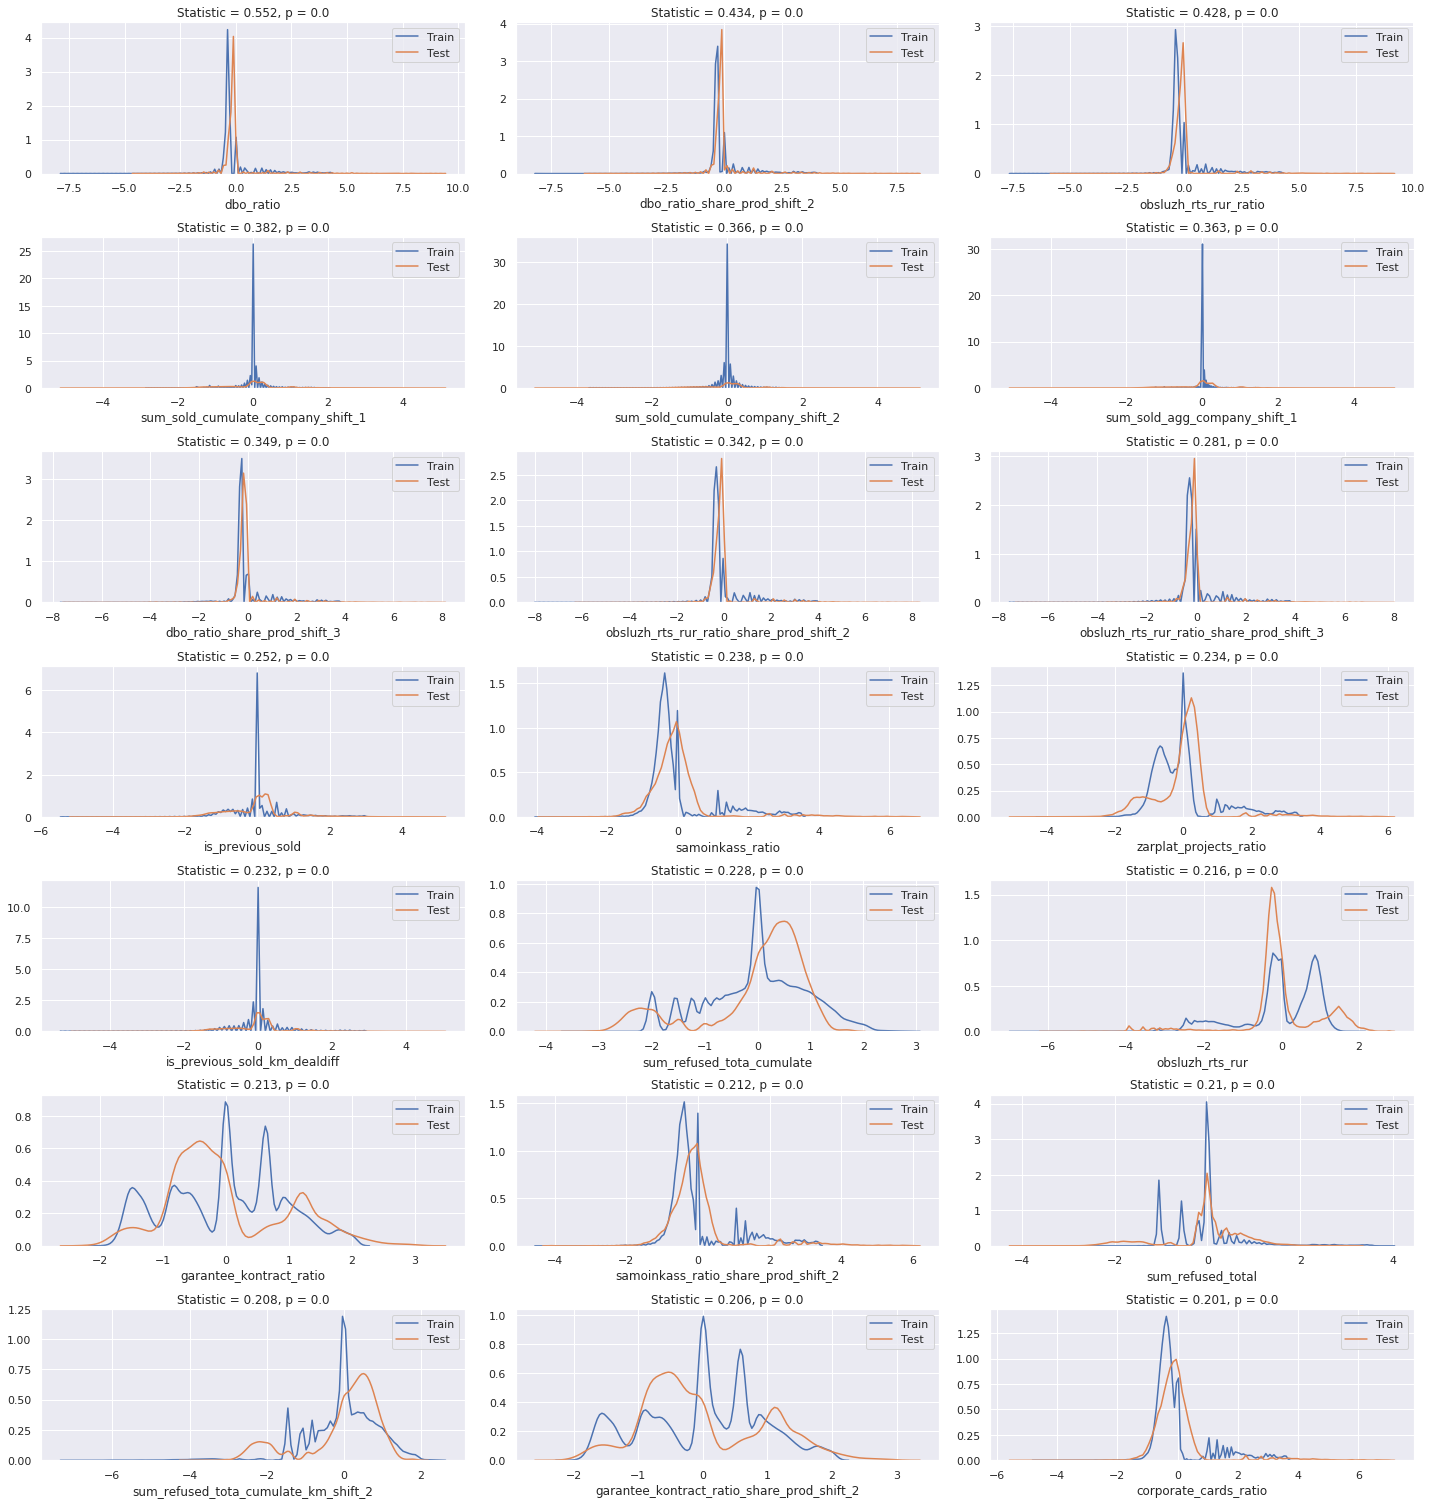

In [69]:
# Get the columns which differ a lot between test and train
diff_df = fe.get_diff_columns(
    tot_df_scl.iloc[train_idx], tot_df_scl.iloc[test_idx],
    threshold=0.15, kde=True
)

In [75]:
len(set(diff_df.feature)-set(cat_features+cattopoly))

54

In [76]:
joblib.dump(diff_df, get_path('pkl_store', 'KS_diff_df.pkl'))

['pkl_store/KS_diff_df.pkl']

## Boosting Aggregation

In [77]:
X_test, X_train, y_test, y_train = train_test_split(X, y, shuffle=False, test_size=0.70, random_state=42)

In [78]:
null_compare = pd.DataFrame(X_train.isnull().sum(), columns=['train_null_count'])
null_compare['train_null_ratio'] = null_compare['train_null_count'] / X_train.shape[0] * 100
null_compare = null_compare.join(X_test.isnull().sum().rename('test_null_count'))
null_compare['test_null_ratio'] = null_compare['test_null_count'] / X_test.shape[0] * 100
null_compare['diff_abs'] = np.abs(null_compare['train_null_ratio'] - null_compare['test_null_ratio'])
null_compare.sort_values('diff_abs', ascending=False)

,train_null_count,train_null_ratio,test_null_count,test_null_ratio,diff_abs
invest_kredit_ratio_share_prod_shift_3,108782,34.883803,121528,90.933443,56.049640
invest_kredit_ratio_share_prod_shift_2,95870,30.743231,115630,86.520259,55.777028
sum_refused_tota_cumulate_agg_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_refused_cumulate_agg_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_sold_cumulate_agg_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_sold_total_cumulate_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_sold_total_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_refused_tota_cumulate_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_sold_cumulate_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_sold_total_cumulate_agg_km_shift_3,14,0.004489,63025,47.158517,47.154027


In [79]:
X_train_meta=X_train.copy()
X_test_meta=X_test.copy()

In [80]:
X_train_meta.shape

(311841, 158)

## Specify a list of estimators to fit the base model

In [82]:
#cls={RandomForestClassifier: 'randomf', LGBMClassifier: 'lightgbm', XGBClassifier: 'xgboost'}
cls={LGBMClassifier: 'lightgbm', XGBClassifier: 'xgboost'}

## Fit the base model to each training fold

<class 'lightgbm.sklearn.LGBMClassifier'>
--------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:213: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  Гарантия - обязательства по договору (Унифицированный), Векселя, Специализированные продукты для малого бизнеса - корпоративное кредитование, ПУ Зарплатный, Доставка денежной наличности и ценностей
New labels:  ДОСТАВКА ДЕНЕЖНОЙ НАЛИЧНОСТИ И ЦЕННОСТЕЙ
New labels:  NaN
New labels:  NaN
Removed 0 constant columns
Removed 0 constant columns
--------------------------------------------------------------------
AUC:0.88259, Precision:0.86103, Recall:0.92665, True:72719 of 84456, Total:78475, Tr:0.50
--------------------------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:213: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  Контрактное кредитование подрядчиков, Индивидуальный овердрафт, Инвестиционное кредитование (кроме строит-ва) (Структурированный)
New labels:  NaN
New labels:  NaN
Removed 0 constant columns
Removed 0 constant columns
--------------------------------------------------------------------
AUC:0.88126, Precision:0.86123, Recall:0.92542, True:72622 of 84324, Total:78475, Tr:0.50
--------------------------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:213: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  Расчетные векселя, Тендерная гарантия (Структурированный), Кредитование внешнеторговых контрактов, Кредитование под залог коммерческой недвижимости, Продвижение бизнеса онлайн
New labels:  NaN
New labels:  NaN
New labels:  B
Removed 0 constant columns
Removed 0 constant columns
--------------------------------------------------------------------
AUC:0.88124, Precision:0.86080, Recall:0.92586, True:72656 of 84405, Total:78474, Tr:0.50
--------------------------------------------------------------------
--------------------------------------------------------------------
AUC: 0.88167, Precision: 0.86102, Recall: 0.92598, True:217997 of 253185, Total:235424
f1_score: 0.89232 

Average precision: 0.95791 



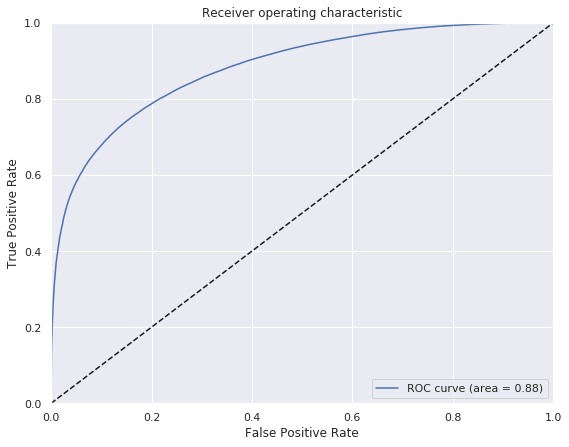

/home/ektov-av/notebooks/myscripts/support_library/plot.py:129: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


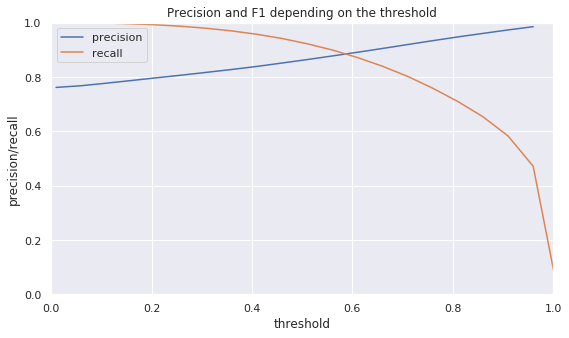

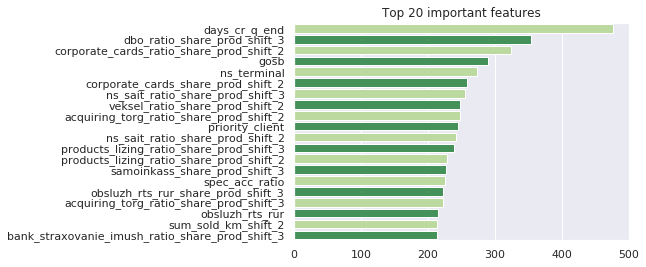

<class 'xgboost.sklearn.XGBClassifier'>
--------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:213: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  Гарантия - обязательства по договору (Унифицированный), Векселя, Специализированные продукты для малого бизнеса - корпоративное кредитование, ПУ Зарплатный, Доставка денежной наличности и ценностей
New labels:  ДОСТАВКА ДЕНЕЖНОЙ НАЛИЧНОСТИ И ЦЕННОСТЕЙ
New labels:  NaN
New labels:  NaN
Removed 0 constant columns
Removed 0 constant columns
--------------------------------------------------------------------
AUC:0.88061, Precision:0.85660, Recall:0.93077, True:73042 of 85270, Total:78475, Tr:0.50
--------------------------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:213: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  Контрактное кредитование подрядчиков, Индивидуальный овердрафт, Инвестиционное кредитование (кроме строит-ва) (Структурированный)
New labels:  NaN
New labels:  NaN
Removed 0 constant columns
Removed 0 constant columns
--------------------------------------------------------------------
AUC:0.87966, Precision:0.85738, Recall:0.93027, True:73003 of 85147, Total:78475, Tr:0.50
--------------------------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:213: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  Расчетные векселя, Тендерная гарантия (Структурированный), Кредитование внешнеторговых контрактов, Кредитование под залог коммерческой недвижимости, Продвижение бизнеса онлайн
New labels:  NaN
New labels:  NaN
New labels:  B
Removed 0 constant columns
Removed 0 constant columns
--------------------------------------------------------------------
AUC:0.87934, Precision:0.85655, Recall:0.92993, True:72975 of 85196, Total:78474, Tr:0.50
--------------------------------------------------------------------
--------------------------------------------------------------------
AUC: 0.87984, Precision: 0.85684, Recall: 0.93032, True:219020 of 255613, Total:235424
f1_score: 0.89207 

Average precision: 0.95709 



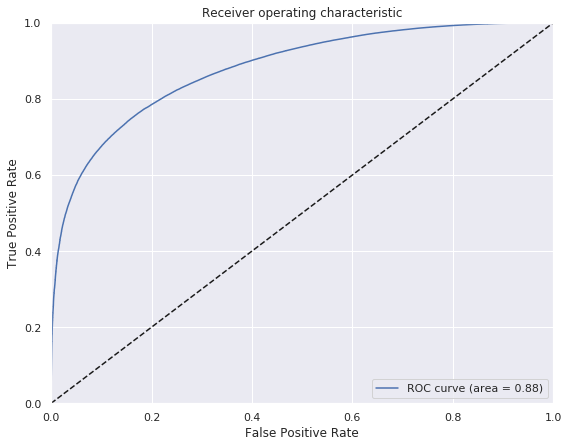

/home/ektov-av/notebooks/myscripts/support_library/plot.py:129: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


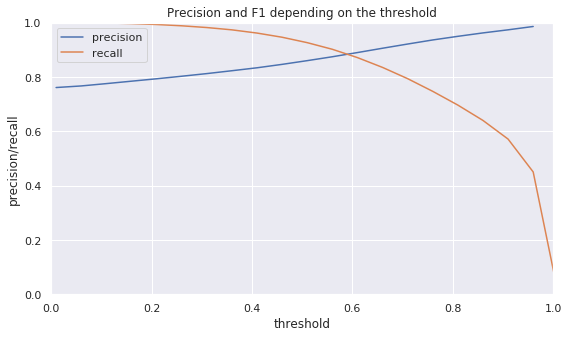

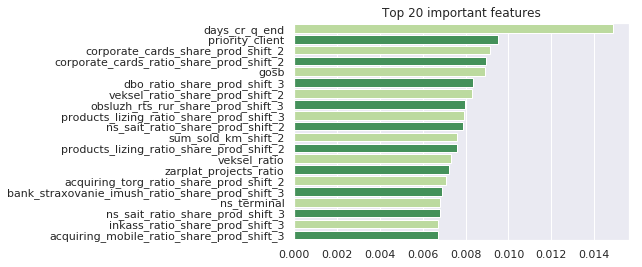

In [33]:
## For each base model
# Fit the base model to the training fold and make predictions on the test fold
# Store tese predictions in X_train_meta to be used as features for the stacking model
for model in list(cls.keys()):
    print(model)
    print('-'*50)
    blend_train, blend_train_proba = train(
                                               X_train, y_train, 
                                               columns=X.columns, 
                                               model_name=model, 
                                               cattopoly=cattopoly,
                                               cat_features=cat_features,
                                               n_folds=3, 
                                               log=True,
                                               threshold=0.5,
                                               save_dict= False
                                          )
    X_train_meta=X_train_meta.join(pd.DataFrame(pd.Series(blend_train, name=cls[model], index=X_train_meta.index)))

In [34]:
joblib.dump(X_train_meta, get_path('pkl_store', 'X_train_KS_meta.pkl'))   

['pkl_store/X_train_KS_meta.pkl']

## Fit the base model to the full training dataset (No Cross-Folding)

<class 'xgboost.sklearn.XGBClassifier'>
--------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:213: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  GM. FX, Прием по объявлению на взнос, Гарантии/контргарантии договорная (возврата аванса), ПУ Безналичный, лизинг конвейер, РКО, Обезличенные метал. счета, ПУ Торговый плюс, Кредитование субъектов РФ и муниципальных образований, Системы ДБО, отличные от СББОЛ/СББ, ПУ Оптима, ПУ Базис, GM. SYNTHETIC DEPO, Контрактное кредитование ЮЛ и ИП, ПФ  (кроме строительства и иных проектов, относящихся к компетенции УФН), Корпоративное кредитование (Структурированный), Сервис проверки контрагентов, ПУ Актив, Индивидуальный овердрафт-Прото, GM. DCD, ПУ Минимальный, Лизинг Фабрика, Еженедельник руководителя, АС Voice-Информатор, Гарантия в пользу налоговых органов, GM. FWD, Финансирование строительства объектов жилой недвижимости
New labels:  ИНВЕСТИЦИОННЫЕ ПРОДУКТЫ
New labels:  NaN
New labels:  NaN
New labels:  A2, A, D2
Removed 0 constant columns
Removed 0 constant columns
--------------------------------------------------------------------
AUC:0.83659, Precision:0.80409, Recall:0.941

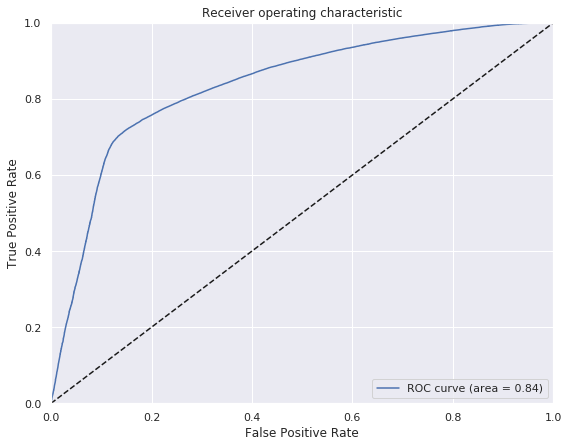

/home/ektov-av/notebooks/myscripts/support_library/plot.py:129: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


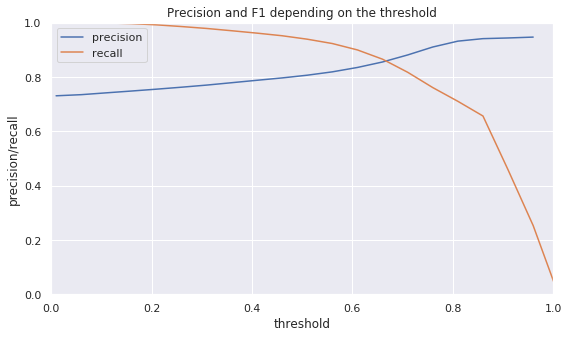

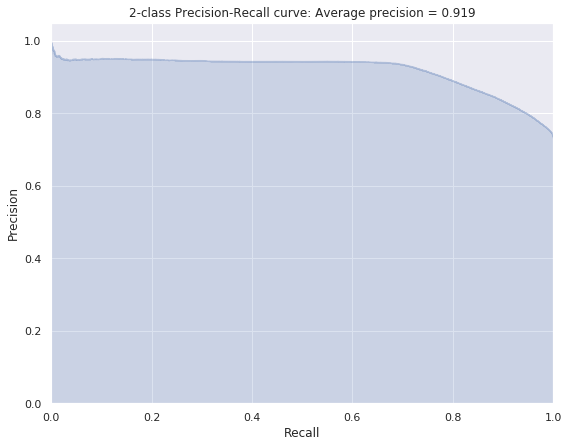

/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


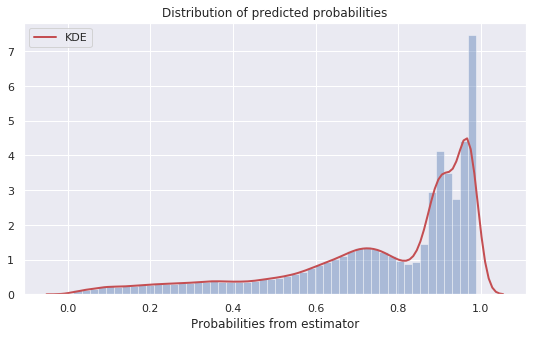

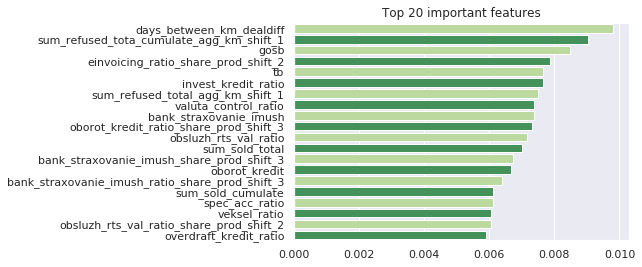

<class 'lightgbm.sklearn.LGBMClassifier'>
--------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:213: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  GM. FX, Прием по объявлению на взнос, Гарантии/контргарантии договорная (возврата аванса), ПУ Безналичный, лизинг конвейер, РКО, Обезличенные метал. счета, ПУ Торговый плюс, Кредитование субъектов РФ и муниципальных образований, Системы ДБО, отличные от СББОЛ/СББ, ПУ Оптима, ПУ Базис, GM. SYNTHETIC DEPO, Контрактное кредитование ЮЛ и ИП, ПФ  (кроме строительства и иных проектов, относящихся к компетенции УФН), Корпоративное кредитование (Структурированный), Сервис проверки контрагентов, ПУ Актив, Индивидуальный овердрафт-Прото, GM. DCD, ПУ Минимальный, Лизинг Фабрика, Еженедельник руководителя, АС Voice-Информатор, Гарантия в пользу налоговых органов, GM. FWD, Финансирование строительства объектов жилой недвижимости
New labels:  ИНВЕСТИЦИОННЫЕ ПРОДУКТЫ
New labels:  NaN
New labels:  NaN
New labels:  A2, A, D2
Removed 0 constant columns
Removed 0 constant columns
--------------------------------------------------------------------
AUC:0.83398, Precision:0.79913, Recall:0.946

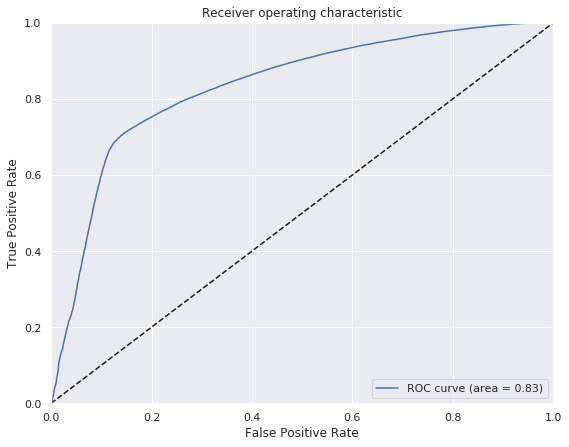

/home/ektov-av/notebooks/myscripts/support_library/plot.py:129: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


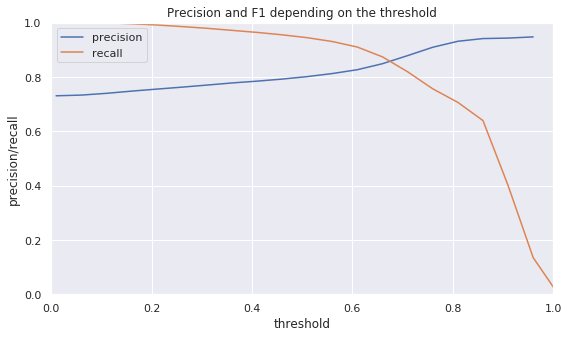

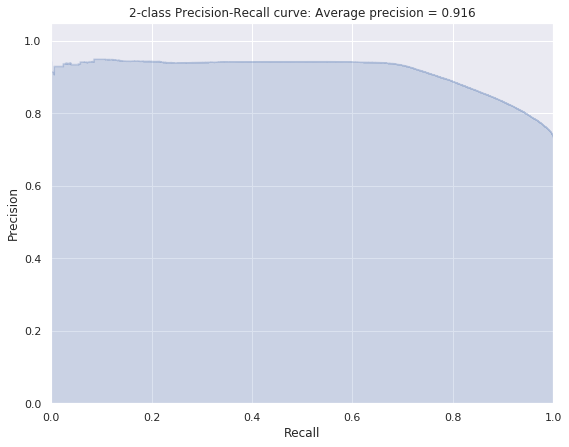

/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


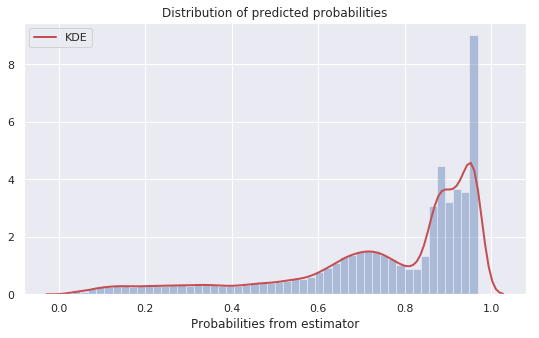

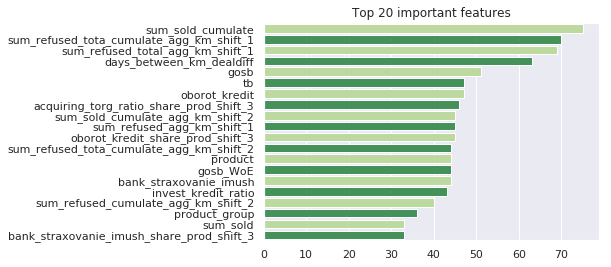

In [83]:
# Fit the base model to the full training dataset and make predictions on the test dataset
# Store tese predictions inside X_test_meta
for model in list(cls.keys()):
    print(model)
    print('-'*50)    
    y_tst, y_tst_proba = train_full(
                                        X_train, X_test, 
                                        y_train, y_test, 
                                        model_name=model, 
                                        cattopoly=cattopoly, 
                                        cat_features=cat_features, 
                                        threshold=0.5,
                                        save_dict= True
                                    )
    
    X_test_meta=X_test_meta.join(pd.DataFrame(pd.Series(y_tst, name=cls[model], index=X_test_meta.index)))

In [36]:
joblib.dump(X_test_meta, get_path('pkl_store', 'X_test_KS_meta.pkl'))

['pkl_store/X_test_KS_meta.pkl']

# Stacking

In [69]:
diff_df = joblib.load(get_path('pkl_store', 'KS_diff_df.pkl'))
toremove=list(set(diff_df.feature)-set(cat_features+cattopoly))

In [70]:
X_train_meta=joblib.load(get_path('pkl_store', 'X_train_KS_meta.pkl'))
X_test_meta=joblib.load(get_path('pkl_store', 'X_test_KS_meta.pkl'))

In [71]:
# Perform features engineering over X_train_meta, X_test_meta
X_train_meta = fe.features_enc_from_dict(X_train_meta, cat_features, cattopoly)
X_test_meta  = fe.features_enc_from_dict(X_test_meta, cat_features, cattopoly)

In [72]:
imp=Imputer(missing_values='NaN', strategy='median', axis=1)
X_train_meta=pd.DataFrame(imp.transform(X_train_meta), columns=X_train_meta.columns)
X_test_meta =pd.DataFrame(imp.transform(X_test_meta), columns=X_test_meta.columns)

X_train_meta=X_train_meta.loc[:,~X_train_meta.columns.isin(toremove)]
X_test_meta=X_test_meta.loc[:,~X_test_meta.columns.isin(toremove)]

X_train_meta,_ = fe.feature_scale_trans(X_train_meta)
X_test_meta,_ = fe.feature_scale_trans(X_test_meta)

Removed 0 constant columns
Removed 0 constant columns


## XGboost

In [100]:
params, fit_params = getboostparams(XGBClassifier, 
                                    X_train_meta, y_train, 
                                    X_test_meta, y_test)
xgb = XGBClassifier(**params)

In [101]:
%%time
xgb.fit(X_train_meta, y_train, **fit_params)

CPU times: user 13min 29s, sys: 12.7 s, total: 13min 42s
Wall time: 21.6 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=10, missing=None, n_estimators=10000,
       n_jobs=60, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1.0)

In [75]:
joblib.dump(xgb, get_path('pkl_store', XGBClassifier.__name__ + '_KS_stack.pkl'), compress=9)

['pkl_store/XGBClassifier_KS_stack.pkl']

/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC: 0.83340, Precision: 0.81086, Recall: 0.93210, F1: 0.86726 

Average precision: 0.91929 

             precision    recall  f1-score   support

          0    0.69096   0.41114   0.51553     36039
          1    0.81086   0.93210   0.86726     97606

avg / total    0.77853   0.79162   0.77241    133645



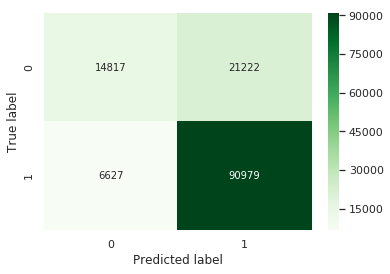

In [76]:
predict(xgb, X_test_meta, y_test)

/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


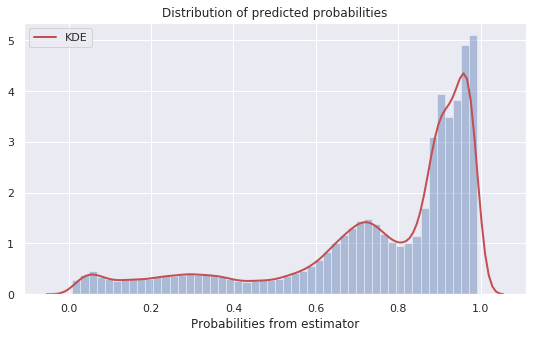

In [77]:
mplt.distplot(xgb.predict_proba(X_test_meta)[:,1])

## LightGBM

In [97]:
params, fit_params = getboostparams(LGBMClassifier, 
                                    X_train_meta, y_train, 
                                    X_test_meta, y_test)
gbm = LGBMClassifier(**params)

In [98]:
%%time
gbm.fit(X_train_meta, y_train, **fit_params)

CPU times: user 5min 17s, sys: 3.36 s, total: 5min 21s
Wall time: 12.1 s


LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting_type='gbdt',
        colsample_bytree=1.0, feature_fraction=0.5, lambda_l1=0,
        lambda_l2=1, learning_rate=0.1, max_bin=100, max_depth=-1,
        min_child_samples=10, min_child_weight=1e-05, min_data_in_leaf=100,
        min_split_gain=0.0, n_estimators=10000, n_jobs=60, num_leaves=150,
        objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

In [80]:
joblib.dump(gbm, get_path('pkl_store', LGBMClassifier.__name__ + '_KS_stack.pkl'), compress=9)

['pkl_store/LGBMClassifier_KS_stack.pkl']

/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC: 0.83541, Precision: 0.81234, Recall: 0.93235, F1: 0.86822 

Average precision: 0.91924 

             precision    recall  f1-score   support

          0    0.69457   0.41666   0.52086     36039
          1    0.81234   0.93235   0.86822     97606

avg / total    0.78058   0.79329   0.77455    133645



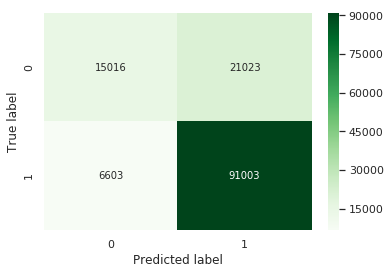

In [81]:
predict(gbm, X_test_meta, y_test)

/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


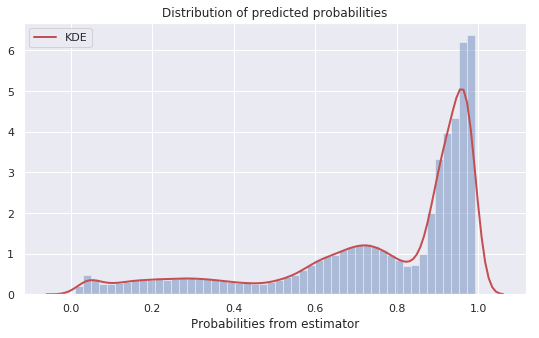

In [82]:
mplt.distplot(gbm.predict_proba(X_test_meta)[:,1])

## Make prediction on a new validation dataset

In [83]:
df_tst = pd.read_pickle('pkl_store/test_dataset_unencoded.pkl')

In [84]:
X_val=df_tst.loc[:,top_corr_features]
X_val_meta=X_val.copy()

In [53]:
le_dict     = joblib.load(get_path('pkl_store', 'le_dict.pkl'))
for col in cat_features:
    ss=set(X_val[col])-set(le_dict[col].get_keys())
    print(list(ss))

[nan, nan, nan, nan]
[]
[nan]
[]
['GM. FX OPTION', 'Спец счет для торгов', 'Гарантии исполнения финансовых обязательств по кредитному договору', 'Факторинг']
['ФАКТОРИНГ', 'СПЕЦ СЧЕТ ДЛЯ ТОРГОВ']


In [85]:
diff_df = joblib.load(get_path('pkl_store', 'KS_diff_df.pkl'))
toremove=list(set(diff_df.feature)-set(cat_features+cattopoly))

In [86]:
X_val_enc = fe.features_enc_from_dict(X_val, cat_features, cattopoly)
X_val_enc=X_val_enc.loc[:,~X_val_enc.columns.isin(toremove)]

imp=Imputer(missing_values='NaN', strategy='median', axis=1)
X_val_enc=pd.DataFrame(imp.transform(X_val_enc), columns=X_val_enc.columns)

X_val_enc,_ = fe.feature_scale_trans(X_val_enc)

New labels:  GM. FX OPTION, Спец счет для торгов, Гарантии исполнения финансовых обязательств по кредитному договору, Факторинг
New labels:  ФАКТОРИНГ, СПЕЦ СЧЕТ ДЛЯ ТОРГОВ
Removed 0 constant columns


In [87]:
cls={LGBMClassifier: 'lightgbm', XGBClassifier: 'xgboost'}

In [88]:
## For each base model
# Fit the base model to the training fold and make predictions on the test fold
# Store tese predictions in X_train_meta to be used as features for the stacking model
for model in list(cls.keys()):
    print(model.__name__)
    cl=joblib.load(get_path('pkl_store', model.__name__+'_f.pkl'))
    y_val_pred=cl.predict(X_val_enc)
    X_val_meta=X_val_meta.join(pd.DataFrame(pd.Series(y_val_pred, name=cls[model], index=X_val_meta.index)))

LGBMClassifier
XGBClassifier


/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [89]:
X_val_meta = fe.features_enc_from_dict(X_val_meta, cat_features, cattopoly)
X_val_meta=X_val_meta.loc[:,~X_val_meta.columns.isin(toremove)]

imp=Imputer(missing_values='NaN', strategy='median', axis=1)
X_val_meta=pd.DataFrame(imp.transform(X_val_meta), columns=X_val_meta.columns)

X_val_meta,_ = fe.feature_scale_trans(X_val_meta)

New labels:  GM. FX OPTION, Спец счет для торгов, Гарантии исполнения финансовых обязательств по кредитному договору, Факторинг
New labels:  ФАКТОРИНГ, СПЕЦ СЧЕТ ДЛЯ ТОРГОВ
Removed 0 constant columns


In [90]:
count=0
y_avr_proba=[]
for model in list(cls.keys()):
    count=count+1
    print(model.__name__)
    cl=joblib.load(get_path('pkl_store', model.__name__+'_KS_stack.pkl'))
    y_val_proba = cl.predict_proba(X_val_meta)
    print(len(y_val_proba))
    if count != len(cls):
        temp=y_val_proba
    else:
        y_avr_proba = (temp+y_val_proba)*0.5

LGBMClassifier
19860
XGBClassifier
19860


In [107]:
y_pred = binarize(y_avr_proba[:,1].reshape(-1,1), threshold=0.5).reshape(-1).astype(int)

/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


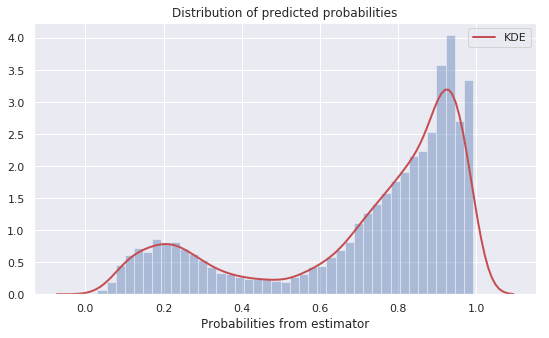

In [92]:
mplt.distplot(y_avr_proba[:,1])

/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


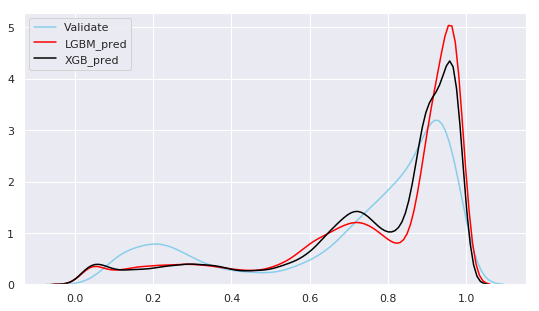

In [102]:
fig = plt.figure(figsize=(9,5))
sns.distplot(y_avr_proba[:,1], label='Validate', color='skyblue', hist=False)
sns.distplot(gbm.predict_proba(X_test_meta)[:,1], label='LGBM_pred', color='red', hist=False)
sns.distplot(xgb.predict_proba(X_test_meta)[:,1], label='XGB_pred', color='black', hist=False)